In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import scipy as sp
from scipy.optimize import minimize
from scipy.stats import gamma as gammadist
from scipy.stats import norm
import pandas as pd
import os
import sys
from matplotlib import pyplot as plt
import GPflow as gpf
import tensorflow as tf

%matplotlib notebook

<IPython.core.display.Javascript object>


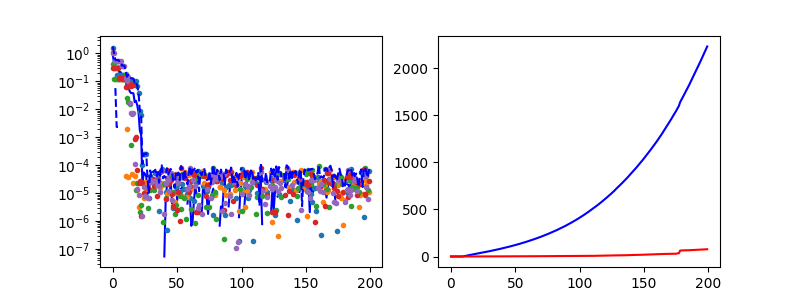

In [114]:
fpath = '/home/mark/Desktop/tmp'
fnames = [i for i in os.listdir(fpath) if i.startswith('eihyp{}_'.format(1)) ]
def getRMV(fpath,fnames,N):
    R = np.empty([N,len(fnames)])
    T = np.zeros([N,2])
    X = np.array(range(N)).astype(float)
    n = len(fnames)
    for j in range(n):    
        f = os.path.join(fpath,fnames[j])
        names = (open(f).readline().strip('\n')+''.join([',q{}'.format(i) for i in range(5)])).replace(' ','')
        df = pd.read_csv(f,names=names.split(','),skiprows=1,engine='c')
        tv = np.array(df['taq'].values)
        R[:,j] = df['trueyatxrecc'].values
        T[:,0] += np.cumsum(tv)
        T[:,1] += np.cumsum(tv)**2
        #print(np.max(np.cumsum(tv)))
        #print(np.max(T))
        #print(T[-1,0],fnames[j])
    M = np.mean(R,axis=1)
    V = np.var(R,axis=1)
    return X,R,M,V,T,n
f,a = plt.subplots(nrows=1,ncols=2,figsize=[8,3])
X,R,M,V,Traw,n = getRMV(fpath,fnames,200)
a[0].plot(X,M,'b')
a[0].plot(X,R,'.')
a[0].plot(X,M+2*np.sqrt(V),'b--')
a[0].semilogy(X,M-2*np.sqrt(V),'b--')
a[1].plot(X,Traw[:,0]/n,'b')
a[1].plot(X,np.sqrt(Traw[:,1]/n-(Traw[:,0]/n)**2),'r')

z = np.linspace(0,220,200)


<IPython.core.display.Javascript object>


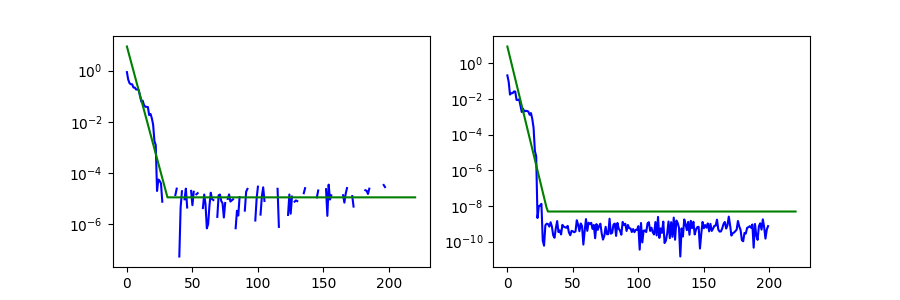

In [70]:
def fitXV(X,M):

    a0=1.
    sigma0=1
    b0=0.1
    c0=1
    def llk(para):
        a = abs(para[0])
        b = abs(para[1])
        c = para[2]
        sigma = abs(para[3])
        pa = gammadist.logpdf(a,4.,scale=1.)
        pa+= gammadist.logpdf(b,4.,scale=0.1)
        pa+= norm.logpdf(c,loc=-3.,scale=2)
        pa+= gammadist.logpdf(sigma,1.,scale=1.)
        
        Yh = np.maximum(c*np.ones_like(X),a-b*X)
        E = np.log(abs(M))-Yh
        return np.sum(((E)**2)/sigma**2)-pa
    res = minimize(llk,[a0,b0,c0,sigma0],method='Nelder-Mead')
    return [abs(res.x[0]),abs(res.x[1]),res.x[2],abs(res.x[3])]

f,a=plt.subplots(nrows=1,ncols=2,figsize=[9,3])
a[0].semilogy(X,M,'b')
a[1].semilogy(X,V,'b')
aV,bV,cV,sigmaV= fitXV(X,V)
aM,bM,cM,sigmaV= fitXV(X,M)
#alphaV,gammaV,sigmaV,betaV = [15,0.6,1e-3,1e-6]
Vz = np.exp(np.maximum(cV*np.ones_like(z),aV-bV*z))
Mz = np.exp(np.maximum(cM*np.ones_like(z),aM-bM*z))
a[1].plot(z,Vz,'g')
a[0].plot(z,Mz,'g')

<IPython.core.display.Javascript object>


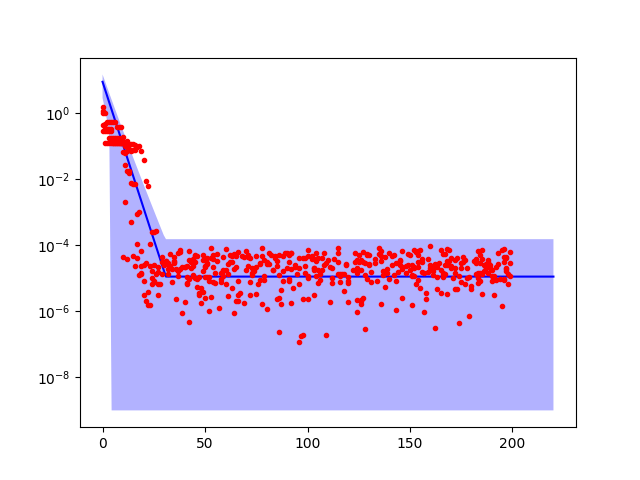

In [71]:
plt.figure()
plt.plot(z,Mz,'b')
plt.fill_between(z,np.maximum(Mz-2*np.sqrt(Vz),1e-9),Mz+2*np.sqrt(Vz),edgecolor=None,facecolor='b',alpha=0.3)
plt.semilogy(X,R,'r.')

In [97]:
def getpara(j):
    fpath = '/home/mark/Desktop/tmp'
    fnames = [i for i in os.listdir(fpath) if i.startswith('eihyp{}_'.format(j)) ]
    batch,number,dim,ls,noise,tail = fnames[0].split('_')
    N = int(tail.strip('.csv')[1:])
    X,R,M,V,Traw,ni= getRMV(fpath,fnames,N)
    thetaM = fitXV(X,M)
    thetaV = fitXV(X,V)
    #print(fnames[0])
    
    
    ls = float(ls[1:])/100.
    noise = 10**-(float(noise[1:])/10.)
    return ls,noise,np.hstack([thetaM,thetaV]),Traw,ni,N
_,_,_,_,_,nopt = getpara(0)
N = np.empty(40)
L = np.empty(40)
D = np.empty([40,8])
Tacc = np.zeros([nopt,2])
nacc = 0
import tqdm
for i in tqdm.tqdm(range(40)):
    L[i],N[i],D[i,:],Traw,ni,_ = getpara(i)
    Tacc+=Traw
    #print(Traw)
    nacc+=ni


100%|██████████| 40/40 [00:18<00:00,  1.98it/s]


<IPython.core.display.Javascript object>


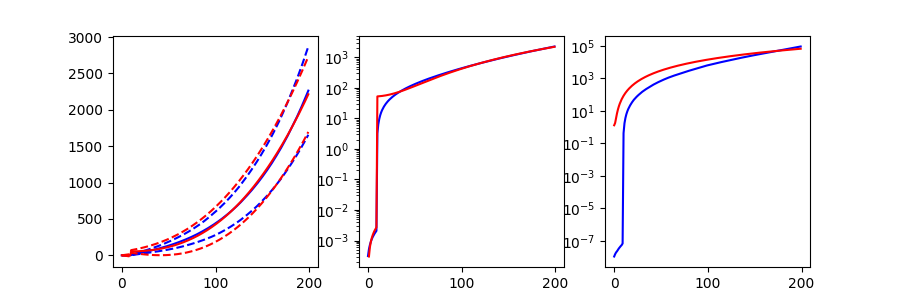

fit model 0.0029488898949269243*x^2.5514007505628564 + 51.41352659062138 +N(0,19.866595031767563)
fit model 0.49006781450711784*x^2.234098630521802 + 1.3072984392989189 +N(0,2853.7471877391717)


In [98]:
Tm = Tacc[:,0]/nacc
Tv = Tacc[:,1]/nacc - (Tacc[:,0]/nacc)**2
f,a = plt.subplots(nrows=1,ncols=3,figsize=[9,3])
a[0].plot(X,Tm,'b')
a[0].plot(X,Tm+2*np.sqrt(Tv),'b--')
a[0].plot(X,Tm-2*np.sqrt(Tv),'b--')
a[1].plot(X,Tm,'b')
a[2].plot(X,Tv,'b')
def llk(X,Y,theta,pr_alpha, pr_beta):
    X=list(X)
    Y=list(Y)
    N=len(X)
    a,b,c,s = theta
    accf=-N*np.log(s)
    accD = np.array([0.,0.,0.,-N/s])
    for i in range(4):
        accf+= (pr_alpha[i]-1.)*np.log(theta[i])-theta[i]*pr_beta[i]
        accD[i] += (pr_alpha[i]-1.)/theta[i] - pr_beta[i]
    for i in range(N):
        error = (a*X[i]**b+c-Y[i])/(s**2)
        accD[0] -= error*(X[i]**b)
        accD[1] -= error*(a*np.log(X[i])*X[i]**b)
        accD[2] -= error
        accD[3] += (error**2)*s
        accf -= (0.5*error**2)*s**2
    #print theta,accf
    return accf,accD


def overheadregression(X,Y):
    #print(X,Y)
    pr_alpha = [4.,8.,10.,2.]
    pr_beta = [2.,4.,1,0.5]
    def f(x):
        l,g =llk(X,Y,x,pr_alpha,pr_beta)
        #print x,-l
        return -l,-g

    res = minimize(f,[1.,2.,1.,1.],method='L-BFGS-B',jac=True,bounds=((1e-6,None),(1.,None),(1e-6,None),(1e-6,None)))#,bounds=((0.,1e3),(0.,1e3),(0.,1e3),(0.,1e3)))
    para = np.abs(res.x)
    print( 'fit model {}*x^{} + {} +N(0,{})'.format(*para))
    return para
para = overheadregression(X[10:],Tm[10:])
oapprox = lambda x:(x>=10)*(para[0]*x**para[1]+para[2])+(x*3*1e-4)*(x<10)
vpara = overheadregression(X[10:],Tv[10:])
vapprox = lambda x:vpara[0]*x**vpara[1]+vpara[2]
Test = oapprox(X)

a[0].plot(X,np.array(oapprox(X)),'r')
a[0].plot(X,np.array(oapprox(X)+2*np.sqrt(vapprox(X))),'r--')
a[0].plot(X,np.array(oapprox(X)-2*np.sqrt(vapprox(X))),'r--')
a[1].semilogy(X,np.array(oapprox(X)),'r')
a[2].semilogy(X,np.array(vapprox(X)),'r')

In [99]:
n

0.0

<IPython.core.display.Javascript object>


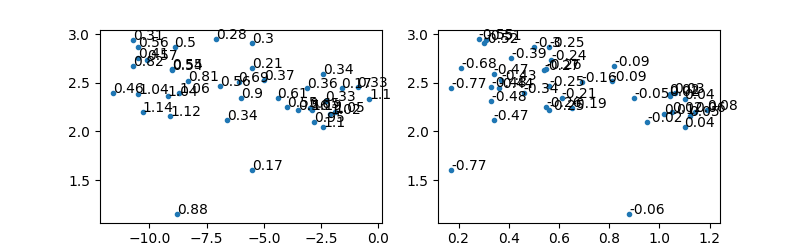

<IPython.core.display.Javascript object>


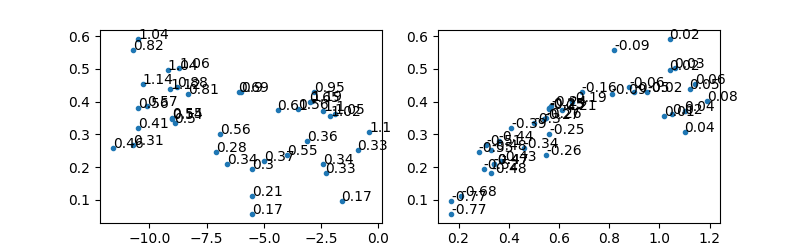

<IPython.core.display.Javascript object>


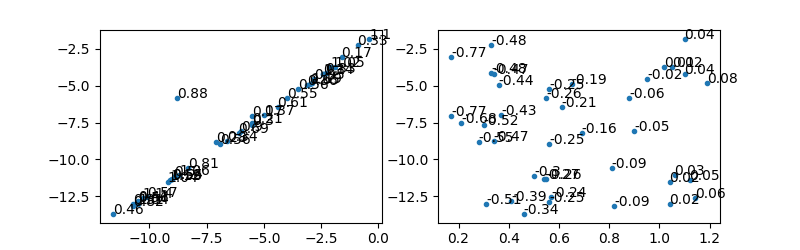

<IPython.core.display.Javascript object>


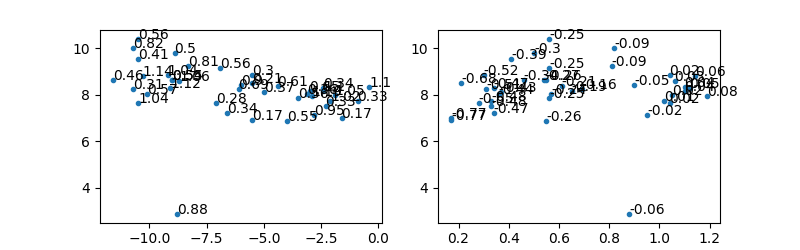

<IPython.core.display.Javascript object>


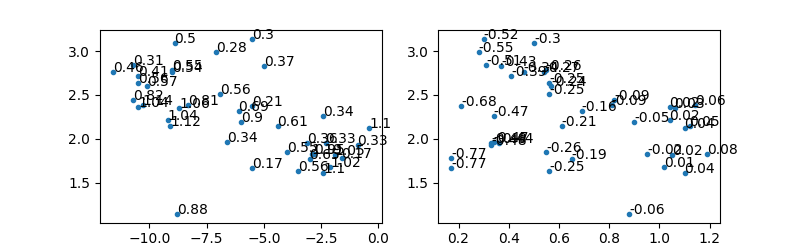

<IPython.core.display.Javascript object>


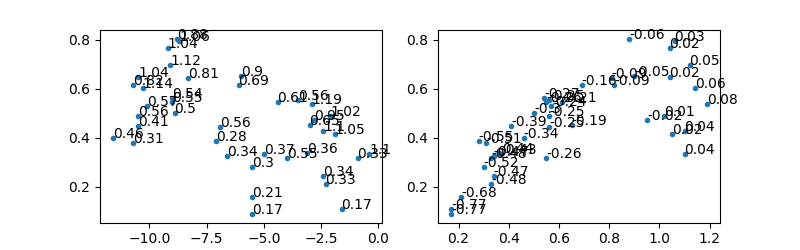

<IPython.core.display.Javascript object>


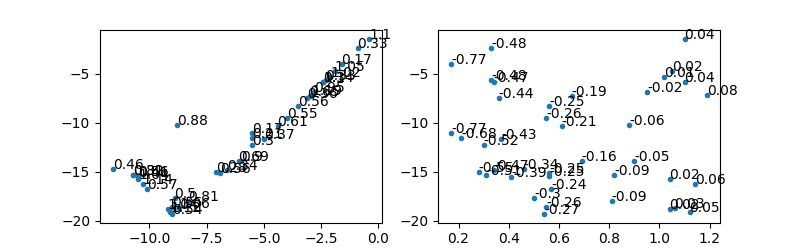

<IPython.core.display.Javascript object>


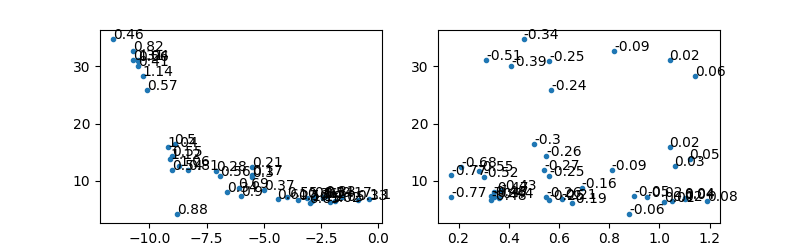

In [100]:
for j in range(8):
    f,a = plt.subplots(nrows=1,ncols=2,figsize=[8,2.5])
    a[0].plot(np.log10(N),D[:,j],'.')
    a[1].plot(L,D[:,j],'.')
    for i in range(N.size):
        a[0].text(np.log10(N)[i],D[i,j],str(L[i]))
        a[1].text(L[i],D[i,j],str(np.round(np.log10(L[i]),2)))

In [101]:
import GPflow as gpf
m=N.size

mtrain=int(0.8*m)
mtest = m-mtrain
print(m,mtrain,mtest)
def fitgp(X,Y,Xt,Yt):
    kr = gpf.kernels.RBF(2,ARD=True)+gpf.kernels.Constant(1)
    g = gpf.gpr.GPR(X,Y,kr)
    g.optimize()
    print(g)
    m,v= g.predict_y(Xt)
    e = m-Yt
    re = e/np.sqrt(v)
    #print(Y-np.mean(Y))
    print(sum(e**2)/float(mtest) , sum((Y-np.mean(Y))**2)/float(mtrain))
    return g
X_tr = np.vstack([L[:mtrain],np.log10(N[:mtrain])]).T
X_te = np.vstack([L[mtrain:],np.log10(N[mtrain:])]).T
g = [None for i in range(8)]
for j in range(8):
    print('{}-------------------'.format(j))
    g[j] = fitgp(X_tr,D[:mtrain,j].reshape([mtrain,1]),X_te,D[mtrain:,j].reshape([mtest,1]))

40 32 8
0-------------------
name.kern.constant.variance transform:+ve prior:None
[ 6.053037]
name.kern.rbf.variance transform:+ve prior:None
[ 0.11036974]
name.kern.rbf.lengthscales transform:+ve prior:None
[ 0.59303757  9.50954743]
name.likelihood.variance transform:+ve prior:None
[ 0.08090194]

[ 0.15155646] [ 0.11011407]
1-------------------
name.likelihood.variance transform:+ve prior:None
[ 0.00165806]
name.kern.rbf.variance transform:+ve prior:None
[ 0.1206155]
name.kern.rbf.lengthscales transform:+ve prior:None
[  0.85272904  27.88185104]
name.kern.constant.variance transform:+ve prior:None
[  4.14291692e-06]

[ 0.00245607] [ 0.01438168]
2-------------------
name.kern.rbf.variance transform:+ve prior:None
[ 303.69622613]
name.kern.rbf.lengthscales transform:+ve prior:None
[ 1292.66030437    24.86903408]
name.kern.constant.variance transform:+ve prior:None
[  1.00000000e-06]
name.likelihood.variance transform:+ve prior:None
[ 0.88982978]

[ 0.11450893] [ 11.17349297]
3----------

In [106]:
lep = np.linspace(0.05,1.2,50)
nop = np.linspace(-12,0.,50)
stops = [int(nopt*i) for i in [0.,0.25,0.5,0.75,1.]]
A=[np.empty([50,50]) for i in stops]
B=[np.empty([50,50]) for i in stops]
def predict(l,n,s):
    p = [q.predict_f(np.array([l,n]).reshape([1,2]))[0][0,0] for q in g]
    m = lambda x :np.exp(np.maximum(p[2],p[0]-p[1]*x))
    v = lambda x :np.exp(np.maximum(p[2],p[4]-p[5]*x)+p[4])
    return m(s),v(s)
for i,l in enumerate(lep):
    for j,n in enumerate(nop):
        mu,var = predict(l,n,np.array(stops))
        for k,s in enumerate(stops):
            A[k][j,i] = mu[k]
            B[k][j,i] = np.sqrt(var[k])
            

0


<IPython.core.display.Javascript object>


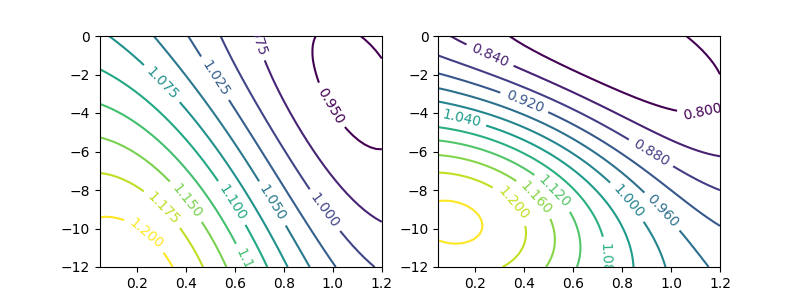

50


<IPython.core.display.Javascript object>


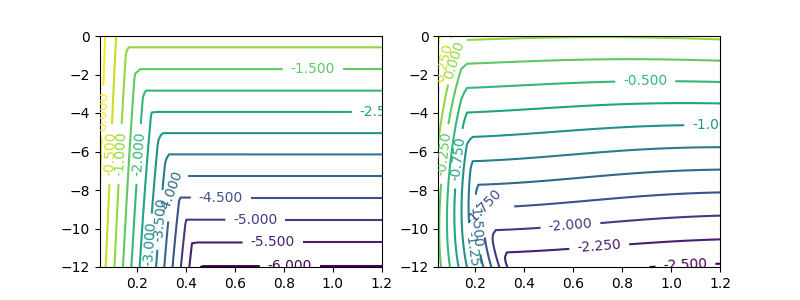

100


<IPython.core.display.Javascript object>


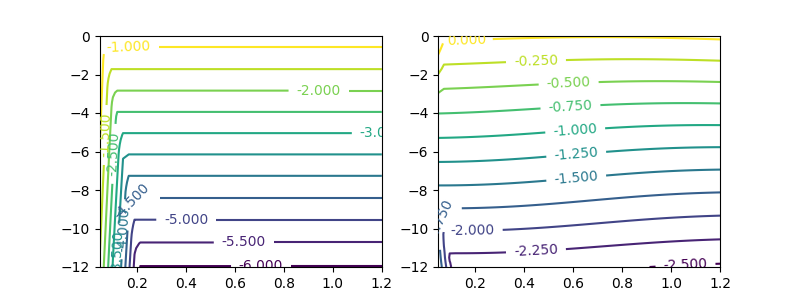

150


<IPython.core.display.Javascript object>


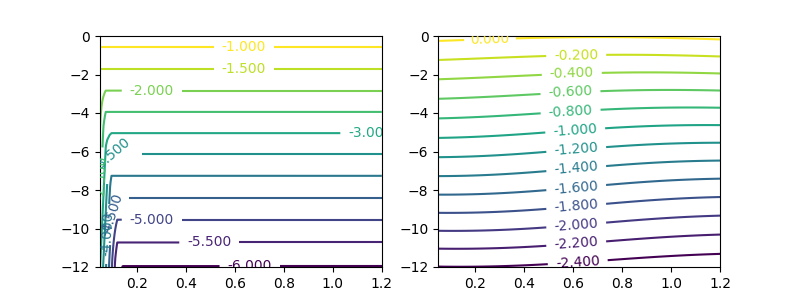

200


<IPython.core.display.Javascript object>


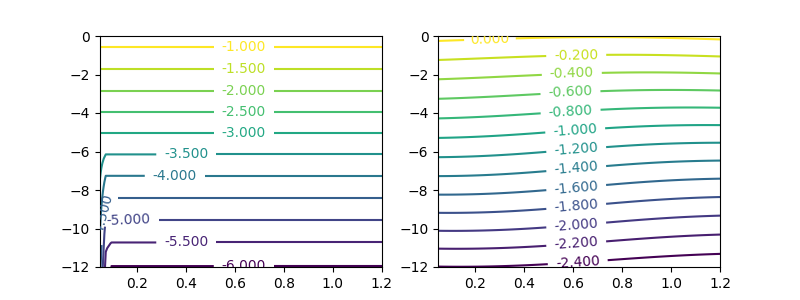

In [107]:
for i in range(len(A)):
    print(stops[i])
    f,a = plt.subplots(nrows=1,ncols=2,figsize=[8,3])
    cs = a[0].contour(lep,nop,np.log10(A[i]),12)
    a[0].clabel(cs, inline=1, fontsize=10)
    cs = a[1].contour(lep,nop,np.log10(B[i]),12)
    a[1].clabel(cs, inline=1, fontsize=10)


<IPython.core.display.Javascript object>


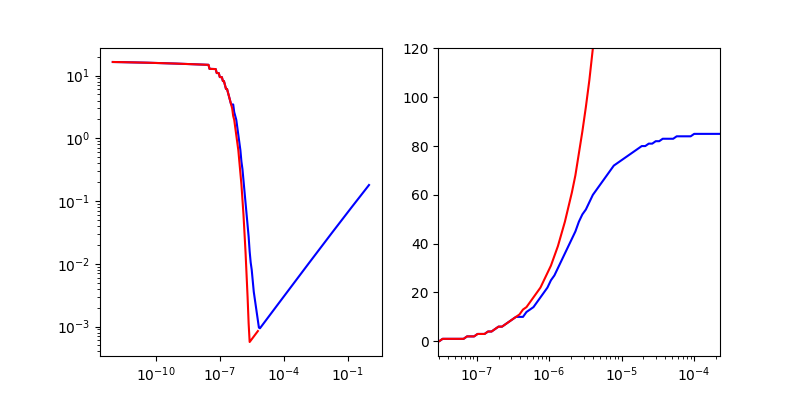

In [110]:
def predictatfixedcost(var,l,B,over=True):
    stepcost = 10*1e-6/var
    predictcost = (np.array(range(200))+1)*stepcost + Test*over
    steps=np.argmax(predictcost>B) if predictcost[-1]>B else 100
    m,v = predict(l,np.log10(var),steps)
    return m,v,steps
s = np.logspace(0,-12,250)
mp = np.empty_like(s)
vp = np.empty_like(s)
sp = np.empty_like(s)
for i,v in enumerate(s):
    mp[i],vp[i],sp[i] = predictatfixedcost(v,0.2,300)
mx = np.empty_like(s)
vx = np.empty_like(s)
sx = np.empty_like(s)
for i,v in enumerate(s):
    mx[i],vx[i],sx[i] = predictatfixedcost(v,0.2,300,over=False)
    if sx[i]==100:
        mx[i]=np.inf
        sx[i]=np.inf
f,a = plt.subplots(nrows=1,ncols=2,figsize=[8,4])
a[0].semilogy(s,mp,'b')
a[1].semilogx(s,sp,'b')
a[0].loglog(s,mx,'r')
a[1].semilogx(s,sx,'r')

In [116]:
def gettest(j):
    fpath = '/home/mark/Desktop/2dtest'
    fnames = [i for i in os.listdir(fpath) if i.startswith('eihyp{}_'.format(j)) ]
    batch,number,dim,ls,noise,tail = fnames[0].split('_')
    N = int(tail.strip('.csv')[1:])
    X,R,M,V,Traw,ni= getRMV(fpath,fnames,N)
    
    ls = float(ls[1:])/100.
    noise = 10**-(float(noise[1:])/10.)
    return M,V,noise
N = np.empty(20)
M = np.empty([nopt,20])
V = np.empty([nopt,20])
for i in tqdm.tqdm(range(20)):
    M[:,i],V[:,i],N[i] = gettest(i)

100%|██████████| 20/20 [00:00<00:00, 30.98it/s]


<IPython.core.display.Javascript object>


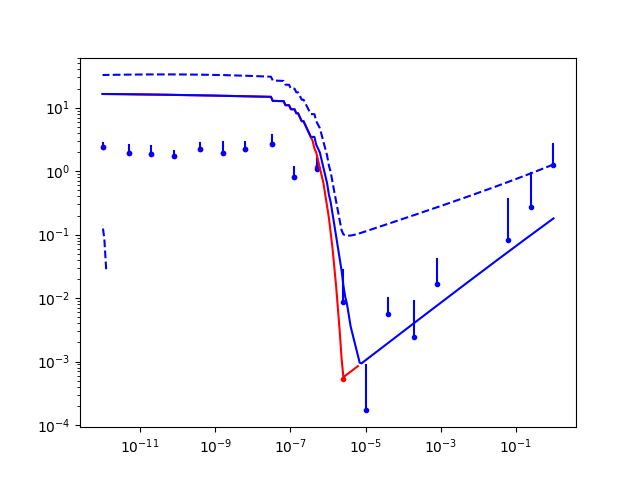

In [152]:
plt.figure()
for i in range(20):    
    nstepsx = sx[np.argmax(N[i]>=s)]
    if not np.isinf(nstepsx):
        mean = M[int(nstepsx),i]
        plt.loglog(N[i],mean,'r.')
    nstepsp = sp[np.argmax(N[i]>=s)]
    if not np.isinf(nstepsp):
        mean = M[int(nstepsp),i]
        plt.loglog(N[i],mean,'b.')
        plt.loglog([N[i],N[i]],[mean,mean+np.sqrt(V[int(nstepsp),i])],'b')
plt.loglog(s,mx,'r')
plt.loglog(s,mp,'b')
plt.loglog(s,mp+np.sqrt(vp),'b--')
plt.loglog(s,mp-np.sqrt(vp),'b--')

array([ 0.13574672,  0.346657  ,  0.40363778,  0.15979081,  0.25232852,
        0.86401014,  0.48833434,  0.89204381,  1.45646947,  0.83345894,
        1.17643927,  1.10950731,  0.98397391,  0.41964123,  0.43725713,
        1.09625494,  0.78850904,  0.10744716,  0.68566358,  2.03236004])

In [140]:
np.isinf

<ufunc 'isinf'>